# (1m)Noise

* **author**: steeve.laquitaine@epfl.ch  
* **purpose**: validation of trace background noise.

### Prerequisites

* preprocess recordings.

### Setup

1. Pre-compute data with mpi on several nodes with `sbatch src/pipes/validation/noise/mpi_npx_full.py`

2. Setup `spikeinterf` venv



In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import multiprocessing
import torch
import copy
import seaborn as sns

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.validation import noise

# vivo
data_conf_v, param_conf_v = get_config("vivo_marques", "c26").values() 
RAW_PATH_v = data_conf_v["raw"]
PREP_PATH_v = data_conf_v["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_v = data_conf_v["validation"]["noise"]["full"]

# silico best fitted gain and noise
data_conf_s, param_conf_s = get_config("silico_neuropixels", "npx_spont").values()
RAW_PATH_s = data_conf_s["probe_wiring"]["full"]["output"]
PREP_PATH_s = data_conf_s["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_s = data_conf_s["validation"]["noise"]["full"]

# Buccino with best fitted gain for layer 5
data_conf_b, _ = get_config("buccino_2020", "2020").values()
RAW_PATH_b = data_conf_b["probe_wiring"]["full"]["output"]
PREP_PATH_b = data_conf_b["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_b = data_conf_b["validation"]["noise"]["full"]

# neuropixels (evoked biophysical model)
cfg_ne, _ = get_config("silico_neuropixels", "npx_evoked").values()
RAW_PATH_ne = cfg_ne["probe_wiring"]["full"]["output"]
PREP_PATH_ne = cfg_ne["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_ne = cfg_ne["validation"]["noise"]["full"]

# parameters
LAYERS = ["L1", "L2/3", "L4", "L5", "L6"]
SFREQ_V = 30000          # sampling frequency
SFREQ_S = 40000        # sampling frequency
SFREQ_B = 32000        # sampling frequency
SFREQ_E = 20000        # sampling frequency

# pipeline parameters
SAVE_FIG = True

# FIGURE SETTINGS
FIG_SIZE = (1.8, 1.6)
COLOR_VIVO = np.array([153, 153, 153]) / 255
COLOR_SILI = np.array([228, 26, 28]) / 255
COLOR_BUCCI = np.array([55, 126, 184]) / 255
COLOR_NE = [1, 0.49, 0]

# experiment colors
cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi": 300}
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-12-05 14:43:09,729 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-05 14:43:09,785 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-05 14:43:09,786 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-05 14:43:09,826 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-05 14:43:09,827 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-05 14:43:09,850 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-05 14:43:09,851 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-05 14:43:09,910 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Specs

In [3]:
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())

available cpus: 72
available gpus: True


### Precompute

* run with mpi on several nodes: `sbatch cluster/validation/noise/mpi_npx_full.sh`

### (1s)Load datasets

* first 10 minutes of recordings


In [19]:
RecV = si.load_extractor(PREP_PATH_v)
RecS = si.load_extractor(PREP_PATH_s)
RecE = si.load_extractor(PREP_PATH_ne)
RecB = si.load_extractor(PREP_PATH_b)

# or load
noise_v = np.load(NOISE_PATH_v, allow_pickle=True)
noise_s = np.load(NOISE_PATH_s, allow_pickle=True)
noise_e = np.load(NOISE_PATH_ne, allow_pickle=True)
noise_b = np.load(NOISE_PATH_b, allow_pickle=True)

/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/binaryrecordingextractor.py:78: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")


### Plot noise

#### Compute plot data

In [20]:
# - get site layers
lyr_v = RecV.get_property("layers")
lyr_s = RecS.get_property("layers")
lyr_e = RecE.get_property("layers")

# build dataset
# vivo
lyr_v[lyr_v == "L2"] = "L2/3"  # standardize
lyr_v[lyr_v == "L3"] = "L2/3"  # standardize
lyr_v[lyr_v == "L2_3"] = "L2/3"  # standardize
in_ctx = np.isin(lyr_v, LAYERS)
v_data = pd.DataFrame(data=np.array(noise_v[in_ctx]), columns=["noise"])
lyr_v = lyr_v[in_ctx]
v_data["layer"] = lyr_v
v_data["experiment"] = "npx (Marques-Smith)"
v_data = v_data.sort_values(by=["layer"])

# - group l2 and l3
# spont.
lyr_s[lyr_s == "L2"] = "L2/3"
lyr_s[lyr_s == "L3"] = "L2/3"
lyr_s[lyr_s == "L2_3"] = "L2/3"
in_ctx = np.isin(lyr_s, LAYERS)
s_data = pd.DataFrame(data=np.array(noise_s[in_ctx]), columns=["noise"])
lyr_s = lyr_s[in_ctx]
s_data["layer"] = lyr_s
s_data["experiment"] = "Biophy. spont."
s_data = s_data.sort_values(by=["layer"])

# evoked
lyr_e[lyr_e == "L2"] = "L2/3"
lyr_e[lyr_e == "L3"] = "L2/3"
lyr_e[lyr_e == "L2_3"] = "L2/3"
in_ctx = np.isin(lyr_e, LAYERS)
e_data = pd.DataFrame(data=np.array(noise_e[in_ctx]), columns=["noise"])
lyr_e = lyr_e[in_ctx]
e_data["layer"] = lyr_e
e_data["experiment"] = "Biophy. evoked"
e_data = e_data.sort_values(by=["layer"])

# buccino
b_data = pd.DataFrame(data=np.array(noise_b), columns=["noise"])
b_data["layer"] = "L5"
b_data["experiment"] = "Synth. (Buccino)"

# concat
plot_data = pd.concat([v_data, s_data, e_data, b_data], ignore_index=True)

# drop sites outside cortex
mask = np.isin(plot_data["layer"], LAYERS)
plot_data = plot_data[mask]
plot_data = plot_data.sort_values(by=["layer"])

# unit-test
layers = ["L1", "L2/3", "L4", "L5", "L6"]
assert v_data["layer"].unique().tolist() == layers, "wrong layers"
assert s_data["layer"].unique().tolist() == layers, "wrong layers"
assert e_data["layer"].unique().tolist() == layers, "wrong layers"

#### Plot

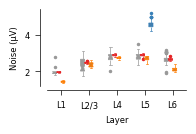

In [ ]:
FIG_SIZE = (1.8, 1)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="noise",
    hue="experiment",
    notch=True,
    hue_order=[
        "npx (Marques-Smith)",
        "Biophy. spont.",
        "Biophy. evoked",
        "Synth. (Buccino)",
    ],
    palette=[cl["COLOR_NV"], cl["COLOR_NS"], cl["COLOR_NE"], cl["COLOR_NB"]],
    width=0.6,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

ax.set_ylabel("Noise (\u03bcV)")
ax.set_xlabel("Layer")

# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            box.set_edgecolor(cl["COLOR_NV"])
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (NV)
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_NV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_NV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (NS)
            box.set_edgecolor(cl["COLOR_NS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NS"])
                ax.lines[k].set_mfc(cl["COLOR_NS"])
                ax.lines[k].set_mec(cl["COLOR_NS"])
            p += 1
        elif p in [10, 11, 12, 13, 14]:
            box.set_edgecolor(cl["COLOR_NE"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NE"])
                ax.lines[k].set_mfc(cl["COLOR_NE"])
                ax.lines[k].set_mec(cl["COLOR_NE"])
            p += 1
        elif p in [15]:
            box.set_edgecolor(cl["COLOR_NB"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NB"])
                ax.lines[k].set_mfc(cl["COLOR_NB"])
                ax.lines[k].set_mec(cl["COLOR_NB"])
            p += 1

# save figures
if SAVE_FIG:
    plt.savefig(
        "figures/0_validation/3_noise/fig2N/fig2N_noise_npx.svg",
        bbox_inches="tight",
        **savefig_cfg
    )

## Hyp. Test

* Mann-Whitnex U test
* non parametric due to some small number of sites

### H0: Does Marques-Smith noise change across layers? Yes

* L1 vs L2/3 same: (p=0.1)
* L2/3 vs L4 differ: (p=5e-7)
* L4 vs L5 same: (p=0.7)
* L5 vs. L6 differ: (p=0.002)

In [24]:
# kruskall-wallis
noise.get_kk(plot_data, "npx (Marques-Smith)")

# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
noise.get_posthoc_dunn_holm_sidak(plot_data, "npx (Marques-Smith)")

H=62.47102557681285, p=8.768468370671957e-13
N_L1 = 10 sites
N_L23 = 42 sites
N_L4 = 34 sites
N_L5 = 42 sites
N_L6 = 98 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,1.994596e-01,4.151756e-06,6.565789e-07,0.000608
L2/3,1.994596e-01,1.000000e+00,8.488219e-07,1.285973e-08,0.000608
L4,4.151756e-06,8.488219e-07,1.000000e+00,6.709225e-01,0.031099
L5,6.565789e-07,1.285973e-08,6.709225e-01,1.000000e+00,0.003946
L6,6.084312e-04,6.084312e-04,3.109947e-02,3.945615e-03,1.000000


### H1: Does spont. change across layers?

In [28]:
# kruskall-wallis
noise.get_kk(plot_data, "Biophy. spont.")

# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
noise.get_posthoc_dunn_holm_sidak(plot_data, "Biophy. spont.")

H=178.66644908122998, p=1.441853196249705e-37
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,1.183958e-01,1.870222e-14,3.766389e-20,1.519809e-07
L2/3,1.183958e-01,1.000000e+00,2.060565e-14,1.038202e-25,5.897085e-07
L4,1.870222e-14,2.060565e-14,1.000000e+00,9.783066e-01,2.860315e-05
L5,3.766389e-20,1.038202e-25,9.783066e-01,1.000000e+00,2.081786e-09
L6,1.519809e-07,5.897085e-07,2.860315e-05,2.081786e-09,1.000000e+00


### H2: Does evoked change across layers?

In [27]:
# kruskall-wallis
noise.get_kk(plot_data, "Biophy. evoked")

# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
noise.get_posthoc_dunn_holm_sidak(plot_data, "Biophy. evoked")

H=171.6940162304055, p=4.527651062676017e-36
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,5.437571e-08,1.356746e-14,6.028772e-20,1.100980e-02
L2/3,5.437571e-08,1.000000e+00,4.034968e-04,2.139625e-06,1.015882e-05
L4,1.356746e-14,4.034968e-04,1.000000e+00,9.394535e-01,7.086785e-13
L5,6.028772e-20,2.139625e-06,9.394535e-01,1.000000e+00,3.446049e-24
L6,1.100980e-02,1.015882e-05,7.086785e-13,3.446049e-24,1.000000e+00


### H3: Spont. Model and data noises are the same? - Yes

In [25]:
print("\nlayer 1\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L1")

print("\nlayer 2/3\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L2/3")

print("\nlayer 4\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L4")

print("\nlayer 5\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L5")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Synth. (Buccino)", "L5")

print("\nlayer 6\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L6")


layer 1

1 vs. 2, z=66.0, p=0.48379408987835437, N_1=10, N_2=16

layer 2/3

1 vs. 2, z=719.0, p=0.02741632075746762, N_1=42, N_2=47

layer 4

1 vs. 2, z=227.0, p=0.07638507627249845, N_1=34, N_2=19

layer 5

1 vs. 2, z=768.0, p=0.0134009597257908, N_1=42, N_2=52
1 vs. 2, z=0.0, p=8.341564166878022e-59, N_1=42, N_2=384

layer 6

1 vs. 2, z=2933.0, p=0.19122888444827751, N_1=98, N_2=68


### H4: Evoked. Model and data noises are the same - No

In [29]:
print("\nlayer 1\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L1")

print("\nlayer 2/3\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L2/3")

print("\nlayer 4\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L4")

print("\nlayer 5\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L5")

print("\nlayer 6\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L6")


layer 1

1 vs. 2, z=160.0, p=3.765248078076184e-07, N_1=10, N_2=16

layer 2/3

1 vs. 2, z=766.0, p=0.06981865287214553, N_1=42, N_2=47

layer 4

1 vs. 2, z=326.0, p=0.9633700684150693, N_1=34, N_2=19

layer 5

1 vs. 2, z=945.0, p=0.266600772419991, N_1=42, N_2=52

layer 6

1 vs. 2, z=6438.0, p=2.208498867696382e-33, N_1=98, N_2=68
